In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
# from torchmetrics.functional.image import image_gradients
import torch.optim as optim
import numpy as np
import time
import math
import pickle
import matplotlib.pyplot as plt
import cv2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class coarseNet(nn.Module):
    def __init__(self, in_channel=3, channels=(96, 256, 384, 384, 256),
                 kernel_sizes=(11, 5, 3, 3, 3), strides=(4,1,1,1,2),
                 paddings=(0,2,1,1,0), name="coarseNet"):
        super(coarseNet, self).__init__()
        self.name = name
        self.stages = nn.ModuleList()
        self.stages.append(nn.Sequential(
            nn.Conv2d(in_channel, channels[0], kernel_sizes[0], strides[0], paddings[0]),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
        ))
        self.stages.append(nn.Sequential(
            nn.Conv2d(channels[0], channels[1], kernel_sizes[1], strides[1], paddings[1]),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
        ))
        for i in range(1, len(channels)-1):
            self.stages.append(nn.Sequential(
                nn.Conv2d(channels[i], channels[i+1], kernel_sizes[i+1], strides[i+1], paddings[i+1]),
                nn.ReLU(inplace=True)
            ))
        # (6*9*256 = 13824)
        self.fc1 = nn.Linear(13824, 6144)
        self.fc2 = nn.Linear(6144, 4800)
        # 4800 = 60*80
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        """
        input size: [n, H, W, C] = [n, 3, 240, 320]
        3*240*320 -> 96*29*39 -> 256*14*19 -> 384*14*19 -> 384*14*19 -> 256*6*9
        """
        for stage in self.stages:
            x = stage(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 1, 60, 80)
        return x

class fineNet(nn.Module):
    def __init__(self, name="fineNet"):
        super(fineNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 63, kernel_size = 7, stride = 2, padding=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 5, padding = 2)
        self.conv3 = nn.Conv2d(64, 1, kernel_size = 5, padding = 2)
        self.pool = nn.MaxPool2d(2)
        self.name = "fineNet"

    def forward(self, x, y):
        """
        input size: [n, H, W, C] = [n, 3, 240, 320]
        3*240*320 -> 63*120*160 -> 63*60*80 -> 64*60*80 -> 1*60*80
        """
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.cat((x,y),1)
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
def custom_loss(output, gt_depth):
    # First term: L1 loss of original images
    loss1 = nn.L1Loss()
    l_depth = loss1(output, gt_depth)
    # Second term: L2 loss(MSE)
    loss2 = nn.MSELoss()
    l_ssim = loss2(output, gt_depth)
    loss = l_ssim + l_depth
    return loss

def RMSE(output, gt_depth):
    assert output.shape == gt_depth.shape, \
        "Output and gt_depth sizes don't match!"
    diff = output - gt_depth
    diff2 = torch.pow(diff, 2)
    mse = torch.mean(diff2)
    rmse = torch.sqrt(mse)
    return rmse

def RMSE_log(output, gt_depth):
    assert output.shape == gt_depth.shape, \
        "Output and gt_depth sizes don't match!"
    output_log = torch.log(torch.clamp(output, min=1e-4, max=80.0))
    gt_depth_log = torch.log(torch.clamp(gt_depth, min=1e-4, max=80.0))
    diff_log = output_log - gt_depth_log
    rmse_log = torch.sqrt(torch.mean(torch.pow(diff_log , 2)))
    # diff2 = torch.pow(diff_log, 2)
    # mse_log = torch.div(torch.sum(diff2), output.numel())
    # rmse_log = torch.sqrt(mse_log)
    return rmse_log

def ABS_rel(output, gt_depth):
    assert output.shape == gt_depth.shape, \
        "Output and gt_depth sizes don't match!"
    output = torch.clamp(output, min=1e-4, max=80.0)
    gt_depth = torch.clamp(gt_depth, min=1e-4, max=80.0)
    diff_abs = torch.abs(output - gt_depth)
    diff_rel = diff_abs / gt_depth
    # print(diff_rel.shape)
    # print(diff_rel)
    abs_rel = torch.mean(diff_rel)

    return abs_rel

def SQ_rel(output, gt_depth):
    assert output.shape == gt_depth.shape, \
        "Output and gt_depth sizes don't match!"
    output = torch.clamp(output, min=1e-4, max=80.0)
    gt_depth = torch.clamp(gt_depth, min=1e-4, max=80.0)
    diff = output - gt_depth
    sq_rel = torch.mean(torch.pow(diff, 2) / gt_depth)
    # diff2 = torch.pow(diff, 2)
    # diff_rel = torch.div(diff2, gt_depth)
    # sq_rel = torch.div(torch.sum(diff_rel), output.numel())
    return sq_rel

def eval_threshold_acc(output, gt_depth, threeshold_val):
    assert output.shape == gt_depth.shape, \
        "Output and gt_depth sizes don't match!"
    output = torch.clamp(output, min=1e-4, max=80.0)
    gt_depth = torch.clamp(gt_depth, min=1e-4, max=80.0)
    thresh = torch.max((gt_depth / output), (output / gt_depth))

    d1 = torch.sum(thresh < threeshold_val).float() / thresh.numel()
    d2 = torch.sum(thresh < threeshold_val ** 2).float() / thresh.numel()
    d3 = torch.sum(thresh < threeshold_val ** 3).float() / thresh.numel()
    return d1, d2, d3

In [ ]:
def test_fine(model, coarse_model, test_loader):
    model.eval()
    model.cuda()
    coarse_model.eval()
    coarse_model.cuda()
    device = torch.device('cuda')
    eval_fine_loss, eval_rmse, eval_rmse_log, eval_abs_rel, eval_sq_rel = 0,0,0,0,0
    eval_d1, eval_d2, eval_d3 = 0,0,0
    for batch_idx, data in enumerate(test_loader):
        rgb = data[0].to(device)
        depth = data[1].to(device)
        depth = depth.view(-1, 1, 60, 80)
        coarse_output = coarse_model(rgb)
        output = model(rgb, coarse_output)

        loss = custom_loss(output, depth)
        rmse = RMSE(output, depth)
        rmse_log = RMSE_log(output, depth)
        abs_rel = ABS_rel(output, depth)
        sq_rel = SQ_rel(output, depth)
        d1, d2, d3 = eval_threshold_acc(output, depth, 1.25)


        eval_fine_loss += loss.item()
        eval_rmse += rmse.item()
        eval_rmse_log += rmse_log.item()
        eval_abs_rel += abs_rel.item()
        eval_sq_rel += sq_rel.item()
        eval_d1 += d1
        eval_d2 += d2
        eval_d3 += d3

    model.train()
    eval_fine_loss /= (batch_idx+1)
    eval_rmse /= (batch_idx+1)
    eval_rmse_log /= (batch_idx+1)
    eval_abs_rel /= (batch_idx+1)
    eval_sq_rel /= (batch_idx+1)
    eval_d1 /= (batch_idx+1)
    eval_d2 /= (batch_idx+1)
    eval_d3 /= (batch_idx+1)

    return eval_fine_loss, eval_rmse, eval_rmse_log, eval_abs_rel, eval_sq_rel, eval_d1, eval_d2, eval_d3

In [ ]:
def test_coarse(model, test_loader):
    model.eval()
    model.cuda()
    device = torch.device('cuda')
    eval_fine_loss, eval_rmse, eval_rmse_log, eval_abs_rel, eval_sq_rel = 0,0,0,0,0
    eval_d1, eval_d2, eval_d3 = 0,0,0
    for batch_idx, data in enumerate(test_loader):
        rgb = data[0].to(device)
        depth = data[1].to(device)
        depth = depth.view(-1, 1, 60, 80)
        output = model(rgb)

        loss = custom_loss(output, depth)
        rmse = RMSE(output, depth)
        rmse_log = RMSE_log(output, depth)
        abs_rel = ABS_rel(output, depth)
        sq_rel = SQ_rel(output, depth)
        d1, d2, d3 = eval_threshold_acc(output, depth, 1.25)


        eval_fine_loss += loss.item()
        eval_rmse += rmse.item()
        eval_rmse_log += rmse_log.item()
        eval_abs_rel += abs_rel.item()
        eval_sq_rel += sq_rel.item()
        eval_d1 += d1
        eval_d2 += d2
        eval_d3 += d3

    model.train()
    eval_fine_loss /= (batch_idx+1)
    eval_rmse /= (batch_idx+1)
    eval_rmse_log /= (batch_idx+1)
    eval_abs_rel /= (batch_idx+1)
    eval_sq_rel /= (batch_idx+1)
    eval_d1 /= (batch_idx+1)
    eval_d2 /= (batch_idx+1)
    eval_d3 /= (batch_idx+1)

    return eval_fine_loss, eval_rmse, eval_rmse_log, eval_abs_rel, eval_sq_rel, eval_d1, eval_d2, eval_d3

In [ ]:
with open('/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/data/depth_estimation_train10.pkl', 'rb') as f:
    test_set = pickle.load(f)

In [ ]:
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)

In [ ]:
coarse_net = coarseNet()
fine_net = fineNet()
coarse_net.cuda()
fine_net.cuda()

# pretrained_coarseNet_path = '/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/pretrained_models/coarseNet_pretrained_final.pt'
pretrained_coarseNet_path = '/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/pretrained_models/Aug3_coarseNet_final.pt'
coarse_net.load_state_dict(torch.load(pretrained_coarseNet_path))

# pretrained_fineNet_path = '/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/pretrained_models/fineNet_pretrained_final.pt'
pretrained_fineNet_path = '/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/pretrained_models/Aug3_fineNet_final.pt'
fine_net.load_state_dict(torch.load(pretrained_fineNet_path))

<All keys matched successfully>

In [ ]:
# test coarse + fine
eval_fine_loss, eval_rmse, eval_rmse_log, eval_abs_rel, eval_sq_rel, eval_d1, eval_d2, eval_d3 = test_fine(fine_net, coarse_net, test_loader)
print(f"RMSE: {eval_rmse:.2f}, RMSE_log: {eval_rmse_log:.2f}, abs_rel: {eval_abs_rel:.2f}, "
      f"sq_rel: {eval_sq_rel:.2f}, d1: {eval_d1:.3f}, d2: {eval_d2:.3f}, d3: {eval_d3:.3f}")

RMSE: 0.94, RMSE_log: 0.44, abs_rel: 38.16, sq_rel: 87.92, d1: 0.370, d2: 0.734, d3: 0.933


In [ ]:
# test coarse
eval_fine_loss, eval_rmse, eval_rmse_log, eval_abs_rel, eval_sq_rel, eval_d1, eval_d2, eval_d3 = test_coarse(coarse_net, test_loader)
print(f"RMSE: {eval_rmse:.2f}, RMSE_log: {eval_rmse_log:.2f}, abs_rel: {eval_abs_rel:.2f}, "
      f"sq_rel: {eval_sq_rel:.2f}, d1: {eval_d1:.3f}, d2: {eval_d2:.3f}, d3: {eval_d3:.3f}")

RMSE: 0.96, RMSE_log: 0.45, abs_rel: 38.83, sq_rel: 88.77, d1: 0.361, d2: 0.712, d3: 0.923


In [ ]:
with open('/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/data/depth_estimation_train20.pkl', 'rb') as f:
    test_set = pickle.load(f)

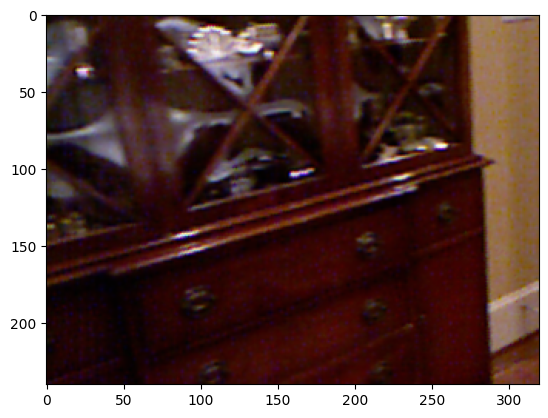

In [ ]:
# Randomly pick an example
index = 528

input_img = test_set[index][0]
gt_depth = test_set[index][1]
coarse_output = coarse_net(input_img.unsqueeze(0).to('cuda'))
fine_output = fine_net(input_img.unsqueeze(0).to('cuda'), coarse_output)

img_np = input_img.cpu().detach().numpy()
gt_depth_np = gt_depth.cpu().detach().numpy()
coarse_output_np = coarse_output.cpu().detach().numpy()
fine_output_np = fine_output.cpu().detach().numpy()

# print(img_np.shape)
# print(gt_depth_np.shape)
# print(coarse_output_np.shape)
# print(fine_output_np.shape)

img_np = np.transpose(img_np, (1,2,0))
plt.imshow(img_np)

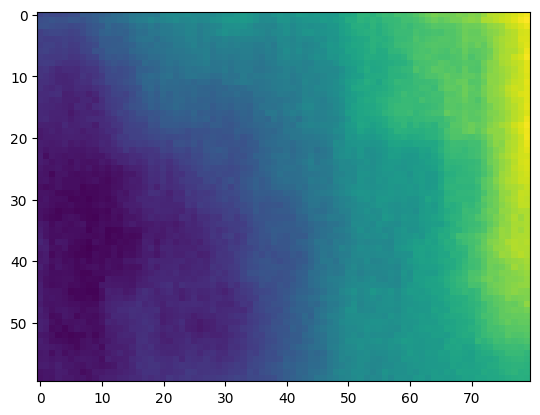

In [ ]:
plt.imshow(coarse_output_np.squeeze())

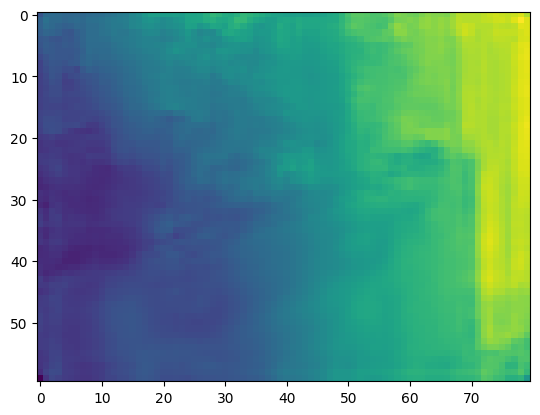

In [ ]:
plt.imshow(fine_output_np.squeeze())

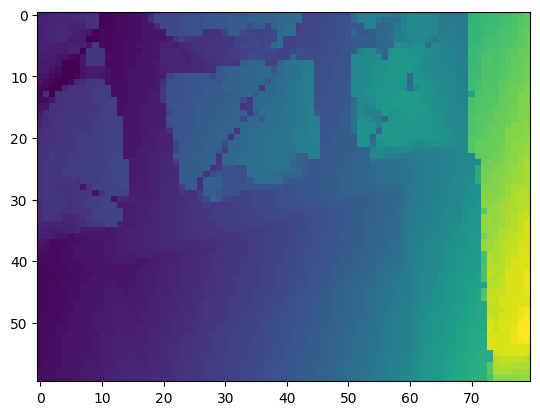

In [ ]:
plt.imshow(gt_depth_np)

In [ ]:
img = cv2.imread("/content/gdrive/MyDrive/APS360-AwareAI/DepthPred/bathroom.png")
img = img/255
print(img.shape)

(240, 320, 3)


In [ ]:
# Convert BGR image to RGB image
img = np.transpose(img, (2, 0, 1))
img = np.float32(img)
img = torch.from_numpy(img)

img = img.unsqueeze(0)
print(img.shape)

torch.Size([1, 3, 240, 320])


In [ ]:
device = torch.device('cuda')
img = img.to(device)
coarse_output = coarse_net(img)
output = fine_net(img, coarse_output)
print(output)

tensor([[[[2.1589, 2.1948, 2.2192,  ..., 1.7169, 1.7009, 1.5690],
          [2.1767, 2.2125, 2.2157,  ..., 1.6792, 1.6921, 1.6163],
          [2.1732, 2.2270, 2.2034,  ..., 1.6596, 1.6932, 1.6769],
          ...,
          [2.0175, 2.0336, 2.0381,  ..., 1.2933, 1.3036, 1.3184],
          [1.9899, 2.0048, 2.0166,  ..., 1.2888, 1.3074, 1.3371],
          [1.9504, 1.9960, 2.0114,  ..., 1.2927, 1.3176, 1.3205]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)


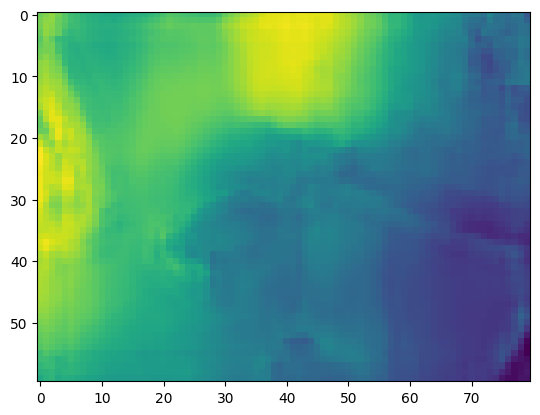

In [ ]:
output = output.squeeze()
output = output.cpu().detach().numpy()
plt.imshow(output)